<a href="https://colab.research.google.com/github/mehdimsv/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/gold_price_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Sep 29 10:05:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
try:
  from tqdm import tqdm
except :
  !pip install --quiet tqdm==4.59.0
  from tqdm import tqdm

In [2]:
dir_path="gdrive/My Drive/ML4T/gold_prediction"
file_name="XAUUSD15_final.csv"

In [3]:
import os
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [17]:
print(os.getcwd())
!ls

/content
gdrive	sample_data


In [20]:
!cd gdrive
!ls


/bin/bash: line 0: cd: gdrive: Transport endpoint is not connected
gdrive	sample_data


In [4]:
if not os.getcwd().endswith("gold_prediction"):
  os.chdir(dir_path)

In [5]:
import pandas as pd
import numpy as np

In [128]:
df=pd.read_csv(file_name)
#df.set_index("date",inplace=True)

In [110]:
df.head()

,date,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9,day_of_month_10,day_of_month_11,day_of_month_12,day_of_month_13,day_of_month_14,day_of_month_15,day_of_month_16,day_of_month_17,day_of_month_18,day_of_month_19,day_of_month_20,day_of_month_21,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31,day_0,day_1,day_2,day_3,day_4,day_6,hour_0,hour_1,...,percent_avg_candle_size_9,percent_avg_candle_size_20,candle_schema_0,candle_schema_1,candle_schema_2,candle_schema_3,candle_schema_4,candle_schema_5,candle_schema_6,candle_schema_7,candle_schema_8,candle_schema_9,sma5_-1,sma5_1,sma14_-1,sma14_1,sma21_-1,sma21_1,ema5_-1,ema5_1,ema14_-1,ema14_1,ema200_-1,ema200_1,mid_-1,mid_1,upper_band_-1,upper_band_1,lower_band_-1,lower_band_1,candle_type_-1,candle_type_0,candle_type_1,intersect_with_previous_candle,current_label_-1,current_label_0,current_label_1,label_-1,label_0,label_1
0,2012-10-25 00:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.66,0,1,0,0,1,0
1,2012-10-25 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.80,1,0,0,0,1,0
2,2012-10-25 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,1,1,0,0,1,1,1,1,1,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0.43,1,0,0,0,1,0
3,2012-10-25 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,0,1,0.88,0,0,1,0,1,0
4,2012-10-25 01:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.93,0,1,0,0,1,0


##Convert label categories to one column

In [129]:
cols=list(df.columns.values[1:])
data_df=df.loc[:,cols]

In [130]:
print(df.columns.values)

['date' 'day_of_month_1' 'day_of_month_2' 'day_of_month_3'
 'day_of_month_4' 'day_of_month_5' 'day_of_month_6' 'day_of_month_7'
 'day_of_month_8' 'day_of_month_9' 'day_of_month_10' 'day_of_month_11'
 'day_of_month_12' 'day_of_month_13' 'day_of_month_14' 'day_of_month_15'
 'day_of_month_16' 'day_of_month_17' 'day_of_month_18' 'day_of_month_19'
 'day_of_month_20' 'day_of_month_21' 'day_of_month_22' 'day_of_month_23'
 'day_of_month_24' 'day_of_month_25' 'day_of_month_26' 'day_of_month_27'
 'day_of_month_28' 'day_of_month_29' 'day_of_month_30' 'day_of_month_31'
 'day_0' 'day_1' 'day_2' 'day_3' 'day_4' 'day_6' 'hour_0' 'hour_1'
 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6' 'hour_7' 'hour_8' 'hour_9'
 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14' 'hour_15' 'hour_16'
 'hour_17' 'hour_18' 'hour_19' 'hour_20' 'hour_21' 'hour_22' 'hour_23'
 'min30' 'momentum5' 'momentum14' 'macd' 'macdsignal' 'macdhist' 'bbp'
 'atr5' 'atr14' 'adx5' 'adx14' 'percent_of_body'
 'percent_avg_candle_size_9' 'perc

In [131]:
data_df["label"]=df.apply(lambda row: 0 if row["label_-1"]==1 else 1 if row["label_0"]==1 else 2,axis=1)
data_df.head()

,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9,day_of_month_10,day_of_month_11,day_of_month_12,day_of_month_13,day_of_month_14,day_of_month_15,day_of_month_16,day_of_month_17,day_of_month_18,day_of_month_19,day_of_month_20,day_of_month_21,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31,day_0,day_1,day_2,day_3,day_4,day_6,hour_0,hour_1,hour_2,...,percent_avg_candle_size_20,candle_schema_0,candle_schema_1,candle_schema_2,candle_schema_3,candle_schema_4,candle_schema_5,candle_schema_6,candle_schema_7,candle_schema_8,candle_schema_9,sma5_-1,sma5_1,sma14_-1,sma14_1,sma21_-1,sma21_1,ema5_-1,ema5_1,ema14_-1,ema14_1,ema200_-1,ema200_1,mid_-1,mid_1,upper_band_-1,upper_band_1,lower_band_-1,lower_band_1,candle_type_-1,candle_type_0,candle_type_1,intersect_with_previous_candle,current_label_-1,current_label_0,current_label_1,label_-1,label_0,label_1,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.66,0,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.80,1,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,1,1,1,1,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0.43,1,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,0,1,0.88,0,0,1,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.93,0,1,0,0,1,0,1


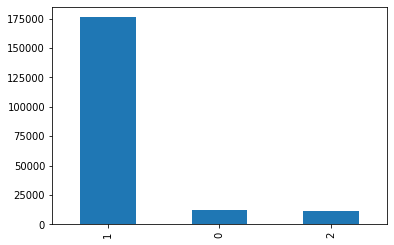

In [11]:
data_df["label"].value_counts().plot(kind="bar")

## 

In [127]:
data_df.head()

,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9,day_of_month_10,day_of_month_11,day_of_month_12,day_of_month_13,day_of_month_14,day_of_month_15,day_of_month_16,day_of_month_17,day_of_month_18,day_of_month_19,day_of_month_20,day_of_month_21,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31,day_0,day_1,day_2,day_3,day_4,day_6,hour_0,hour_1,hour_2,...,adx5,adx14,percent_of_body,percent_avg_candle_size_9,percent_avg_candle_size_20,candle_schema_0,candle_schema_1,candle_schema_2,candle_schema_3,candle_schema_4,candle_schema_5,candle_schema_6,candle_schema_7,candle_schema_8,candle_schema_9,sma5_-1,sma5_1,sma14_-1,sma14_1,sma21_-1,sma21_1,ema5_-1,ema5_1,ema14_-1,ema14_1,ema200_-1,ema200_1,mid_-1,mid_1,upper_band_-1,upper_band_1,lower_band_-1,lower_band_1,candle_type_-1,candle_type_0,candle_type_1,intersect_with_previous_candle,current_label_-1,current_label_0,current_label_1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,64.795922,25.366189,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.66,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,66.157142,26.516325,2,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.80,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,55.877494,26.499606,5,1,1,0,0,1,1,1,1,1,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0.43,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,48.940051,26.601378,7,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,0,1,0.88,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,43.927651,26.741707,2,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0.93,0,1,0


In [125]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df):
  scaler=MinMaxScaler(feature_range=(-1,1))
  cols=df.columns.to_list();

  if "label" in df.columns.to_list():
    cols.remove("label")
    df_labels=df.loc[:,["label"]]
  df[cols] = scaler.fit_transform(df[cols])
  if "label" in df.columns.to_list():
    df["label"]=df_labels
  return df
  
def create_sequences(input_data:pd.DataFrame,target_column,sequence_length):
  sequences=[]
  data_size=len(input_data)
  for i in tqdm(range(data_size - sequence_length)):
    sequence=input_data.iloc[i:i+sequence_length]
    label_position=i+sequence_length
    label=input_data[label_position,target_column]
    sequences.append((sequence,))
  return sequences


In [126]:
NUM_CLASSES=3
percent=0.85
SEQUENCE_LENGTH=120
train_size=int(data_df.shape[0]*percent)
x_train=data_df[:train_size]
x_test=data_df[train_size+1:]
x_train=x_train.dropna()
#x_train=normalize_data(x_train)
x_test=x_test.dropna()
#x_test=normalize_data(x_test)
x_train.head()
train_sequences=create_sequences(x_train,["label_-1","label_0","label_1"],SEQUENCE_LENGTH)
test_sequences=create_sequences(x_test,["label_-1","label_0","label_1"],SEQUENCE_LENGTH)

  0%|          | 0/169689 [00:00<?, ?it/s]


TypeError: ignored

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [36]:
class FeatureDataset(Dataset):
  def __init__(self,sequences):
    self.sequences=sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self,idx):
    sequence,label=self.sequences[idx]
    return torch.Tensor(sequence.to_numpy()),torch.tensor(label).long()

In [37]:
N_EPOCHS=250
BATCH_SIZE=128
train_dataloader=DataLoader(
    FeatureDataset(train_sequences),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True

)
test_dataloader=DataLoader(
    FeatureDataset(test_sequences),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

## Model

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [67]:
class PricePredictionModel(nn.Module):
  def __init__(self,batch_size,n_features,n_classes=3,n_hidden=256,n_layers=3):
    super().__init__()
    self.hidden_dim=n_hidden
    self.n_layers=n_layers
    self.n_classes=n_classes
    self.lstm=nn.LSTM(input_size=n_features,
                      hidden_size=n_hidden,
                      batch_first=True,
                      num_layers=n_layers,
                      dropout=0.7
                      )
    #self.fc1=nn.Linear(n_hidden,256)
    #self.activation1=nn.ReLU()
    #self.dropout1=nn.Dropout(0.5)
    #self.fc2=nn.Linear(256,128)
    #self.activation2=nn.ReLU()
    #self.dropout2=nn.Dropout(0.35)
    self.classifier=nn.Linear(n_hidden,n_classes)
    #self.activation=nn.Softmax()
   
    
  def forward(self,x):
    #print("x shape: ",x.shape)
    batch_size,sequence_length,_=x.shape
    #print("batch_size: ",batch_size)
    #print("seq length:",sequence_length) 
    self.lstm.flatten_parameters()
    output,_=self.lstm(x)

    
    #print("output shape:",output.shape)
    #print("hiddenstate shape: ",hidden_state.shape)
    #reshaped=output.contiguous().view(-1,batch_size,self.hidden_dim)

    #output=self.activation1(self.fc1(output[:,-1]))
    #output=self.dropout1(output)
    #output=self.activation2(self.fc2(output[:,-1]))
    #output=self.dropout2(output)
    #print("reshaped output: ",reshaped.shape)
    return self.classifier(output[:,-1])

  def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        
        return hidden

In [96]:
class DeepModel(nn.Module):
  def __init__(self,batch_size,n_features,n_classes=3,dropout=0.7):
    super(DeepModel,self).__init__()
    self.n_classes=n_classes
    self.fc1=nn.Linear(n_features,1024)
    self.dropout=nn.Dropout(dropout)
    self.fc2=nn.Linear(n_features,512)
    self.dropout2=nn.Dropout(dropout)
    self.classifier=nn.Linear(512,n_classes)

  def forward(self,x):
    print("x shape:",x.shape)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=F.relu(self.fc2(x))
    x=self.dropout(x)
    print("x shape:",x.shape)
    result= self.classifier(x)
    print("result :",result.shape)
    return result

## Model Initialization

In [97]:
#model=PricePredictionModel(BATCH_SIZE,data_df.shape[1])
model=DeepModel(BATCH_SIZE,data_df.shape[1])
model=model.to(device)
#odel.hidden_state=model.init_hidden(BATCH_SIZE)
weights = torch.tensor([0.1,1.5,1.5]).to(device)
loss_fn=nn.CrossEntropyLoss(weight=weights)
optimizer=torch.optim.Adam(model.parameters(),lr=0.005)

In [98]:
print(model)

DeepModel(
  (fc1): Linear(in_features=111, out_features=1024, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc2): Linear(in_features=111, out_features=512, bias=True)
  (dropout2): Dropout(p=0.7, inplace=False)
  (classifier): Linear(in_features=512, out_features=3, bias=True)
)


## Train & Test

In [106]:
def train(dataloader,model,loss_fn,optimizer,epoch):
  size=len(dataloader.dataset)
  #torch.autograd.set_detect_anomaly(True)
  #hidden = model.init_hidden(BATCH_SIZE)
  model.train()
  running_loss=0.0
  running_correct=0.0
  for batch,(X,y) in enumerate(dataloader):
    X=X.to(device)
    y=y.to(device)

    #compute prediction Error
    #hidden=(hidden[0].detach(),hidden[1].detach())
    pred=model(X)
    print("prediction shape:",pred.shape)
    print("y :",y.shape)
    loss=loss_fn(pred,y)
    step_accuracy=accuracy_score(y.detach().to("cpu"),torch.argmax(pred.detach().to("cpu"),dim=1))

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    running_correct+=(torch.argmax(pred.detach(),dim=1)==y).type(torch.float).sum().item()
    if batch % 100==0:
      loss,current=loss.item(),batch*len(X)
      print(f"loss: {loss:>7f}   [{current:>5d}/{size:>5d}], accuracy:{step_accuracy*100}%")
  running_loss/=size
  running_correct/=size
  writer.add_scalar("Loss/train",running_loss , epoch)
  writer.add_scalar("Accuracy/train",running_correct, epoch)
  print(f"Average Loss: {running_loss:>7f}   ,Avg accuracy:{running_correct*100}%")
  writer.flush()

In [107]:
def test(dataloader,model,epoch):
  size=len(dataloader.dataset)
  model.eval()
  test_loss,correct=0,0
  with torch.no_grad():
    for X,y in dataloader:
      X=X.to(device)
      y=y.to(device)
      pred=model(X)
      test_loss+=loss_fn(pred,y).item()
      #step_accuracy=accuracy_score(y.detach().to("cpu"),torch.argmax(pred.detach().to("cpu"),dim=1))
      correct+=(torch.argmax(pred.detach(),dim=1)==y).type(torch.float).sum().item()

  
  test_loss/=size
  correct/=size
  writer.add_scalar("Loss/test", test_loss,epoch)
  writer.add_scalar("Accuracy/test", correct,epoch)
  print(f"Test Error: \n Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f}\n")
  writer.flush()

## Loading TensorBoard

## Training Loop

In [108]:
epochs=250
for epoch in range(epochs):
  print(f"Epoch {epoch+1} \n---------------------------------------")
  train(train_dataloader,model,loss_fn,optimizer,epoch)
  test(test_dataloader,model,epoch)
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, "gold-price-prediction-model-resume.pth")
print("Done!")

Epoch 1 
---------------------------------------
x shape: torch.Size([128, 120, 111])
x shape: torch.Size([128, 120, 512])
result : torch.Size([128, 120, 3])
prediction shape: torch.Size([128, 120, 3])
y : torch.Size([128])


RuntimeError: ignored